In [1]:
from ola_RNN import * 
from ola_cb import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [13]:
class Learner():
    def __init__(self, model, loss_fn, opt, data, lr):
        self.model, self.opt, self.loss_fn, self.data = model, opt, loss_fn, data
        self._lr     = opt.param_groups[0]['lr']
        self.hidden  = None    
        self.stats   = Struct()
        self.stats.valid_loss = []
        self.stats.train_loss = [] 
    
    @property
    def lr(self):
        return self._lr
    
    @lr.setter
    def lr(self,lr):
        self._lr = lr
        for param_group in self.opt.param_groups:
            param_group['lr'] = lr        
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i 
            self.xb,self.yb = xb,yb;                       self('begin_batch')
            self.pred = self.model(self.xb);               self('after_pred')
            self.loss = self.loss_fn(self.pred, self.yb);  self('after_loss')
            if not self.in_train: return
            self.loss.backwards();                         self('after_backward')
            self.opt.step();                               self('after_step')
            self.opt.zero_grad();
        except CancelBatchException:                       self('after_cancel_ batch')
        finally:                                           self('after_batch')
            

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)  

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, combined)
        self.relu2   = nn.ReLU(combined)
        
        self.o3      = nn.Linear(combined, combined)
        self.relu3   = nn.ReLU(combined)
        
        self.o4      = nn.Linear(combined, combined)
        self.relu4   = nn.Linear(combined, combined)
        
        self.o5      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.relu2(output)
        
        output   = self.o3(output)
        output   = self.relu3(output)
        
        output   = self.o4(output)
        output   = self.relu4(output)
        
        output   = self.o5(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))        
    

In [6]:
def one_rnn_batch(xb,yb,cb):
    pred, learn.hidden, loss = rnn_forward(cb.learn,cb.learn.hidden,xb,yb)
    if not cb.after_loss(loss): return    
    loss.backward()
    if not cb.after_backward(): return 
    cb.learn.opt.step()
    if not cb.after_step(): return
    cb.learn.opt.zero_grad()

def fit_rnn(epoches, learn, cb=None, valid_loss=[], itters=math.inf):
    hidden = learn.model.initHidden(15)
    if not cb.begin_fit(learn):           return 
    for epoch in range(epoches):
        if not cb.begin_epoch(epoch):     return             
        for xb, yb in iter(learn.data.train_dl):   
            if not cb.begin_batch(xb,yb): return   
            one_rnn_batch(xb,yb,cb)
            if not cb.after_batch():      return             
            if not cb.begin_validate():   return     
            if cb.do_stop():              break 
        if not cb.after_epoch():          return
    if not cb.after_fit():                return 
    return 

In [7]:
class TestCallback(Callback):
    def begin_fit(self,learn):
        learn.model.train()
        super().begin_fit(learn)
        self.n_iters = 0
        self.n_valids = 0 
        return True
    
    def after_step(self):
        self.n_iters += 1
        return True
    
    def after_batch(self):
        if self.n_iters 

    def begin_epoch(self,epoch):
        self.epoch = epoch 
        return True
    
    def begin_validate(self):
        self.n_valids += 1
        if self.n_iters%100 == 0:
            self.learn.stats.valid_loss.append(get_valid_rnn(self.learn,itters=30))
        if self.n_valids>=15: self.learn.stop = True
        return True

In [8]:
cb = CallbackHandler([TestCallback()])

In [9]:
bs  = 20
sql = 30 
lr  = 0.0005 

data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,sql,shuffle=False)

model  = cuda(RNN(len(data.decoder), 150, 1))
opt    = optim.RMSprop(model.parameters(), lr)

learn  = Learner(model,  nn.NLLLoss(), opt , data, lr=lr)

In [10]:
fit_rnn(1,learn,cb)

getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting vali

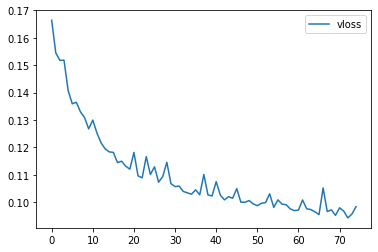

In [11]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.valid_loss))],learn.stats.valid_loss,label='vloss')
# plt.plot([x for x in range(len(emadb))],emadb,label='emadb')       
plt.legend()      